# Feature Engineering and encoding

In [2]:
import pandas as pd

df = pd.read_csv('data/processed/eda_cleaned.csv')

# 1. Check column names
print(df.columns)

# 2. Check for missing values
print(df.isnull().sum())

# 3. Check for duplicates
print(df.duplicated().sum())

# 4. Check target distribution
print(df['Churn'].value_counts(normalize=True))

# 5. Quick outlier check
df.describe()

# 6. Check categorical columns
print(df.select_dtypes(include='object').nunique())

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')
CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64
0
Churn
1.0    0.567108
0.0    0.432892
Name: proportion, dtype: float64
Gender               2
Subscription Type    3
Contract Length      3
dtype: int64


In [4]:
# Example: Create tenure group
if 'tenure' in df.columns:
    df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,36,48,60,72], labels=['0-12','12-24','24-36','36-48','48-60','60-72'])

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns  # <-- Add this line

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# If you created new categorical features, encode them too
if 'tenure_group' in df.columns:
    df['tenure_group'] = le.fit_transform(df['tenure_group'].astype(str))

In [5]:
# 1. Remove columns with too many missing values (if any remain)
missing_thresh = 0.5
cols_to_drop = df.columns[df.isnull().mean() > missing_thresh]
df = df.drop(columns=cols_to_drop)
print("Dropped columns with >50% missing values:", cols_to_drop.tolist())

Dropped columns with >50% missing values: []


In [6]:
# 2. Remove columns with low variance (only one unique value)
low_var_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=low_var_cols)
print("Dropped low variance columns:", low_var_cols)

Dropped low variance columns: []


In [8]:
import numpy as np

In [9]:
# 3. Remove highly correlated features (correlation > 0.9)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(columns=to_drop_corr)
print("Dropped highly correlated columns:", to_drop_corr)

Dropped highly correlated columns: []


In [11]:
# 4. Scale numerical features
from sklearn.discriminant_analysis import StandardScaler


num_cols = df.select_dtypes(include=np.number).columns.drop('Churn', errors='ignore')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Check for Outliers (Boxplot & Z-score)

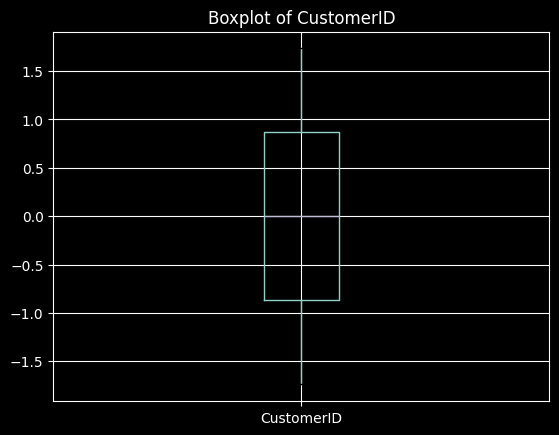

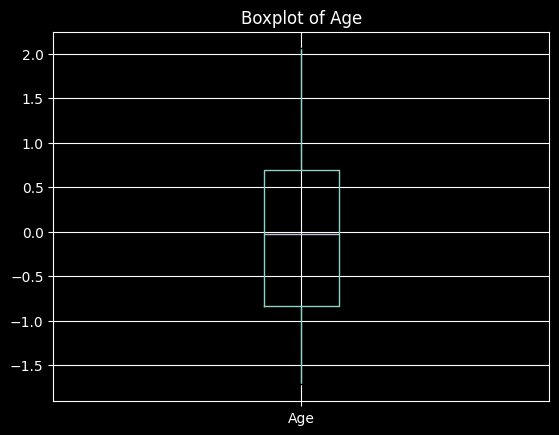

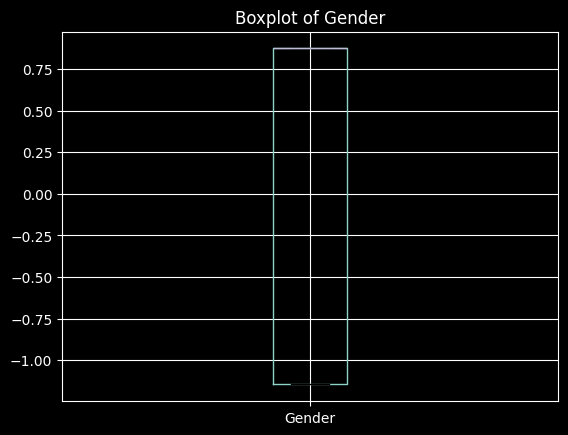

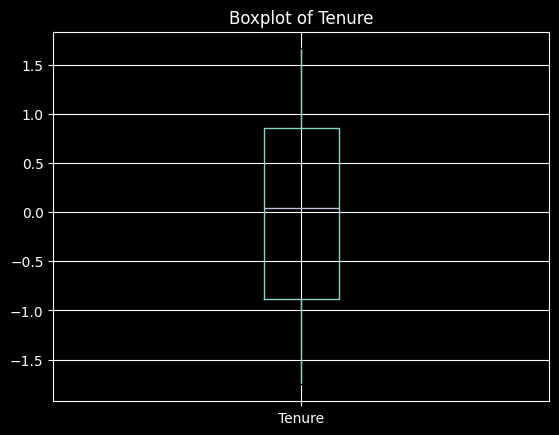

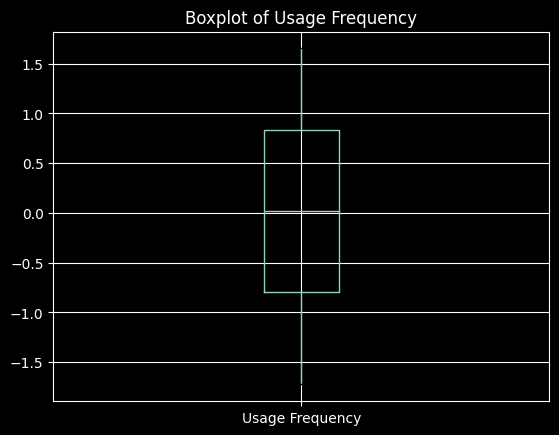

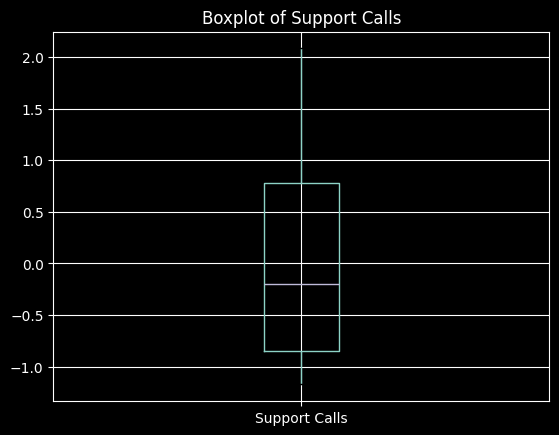

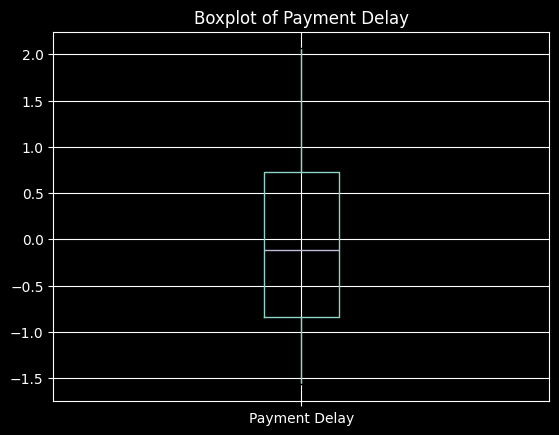

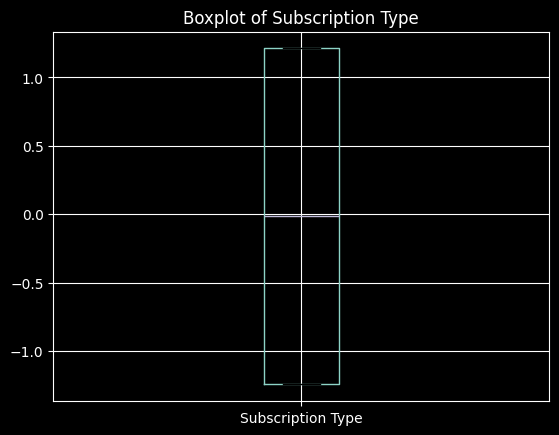

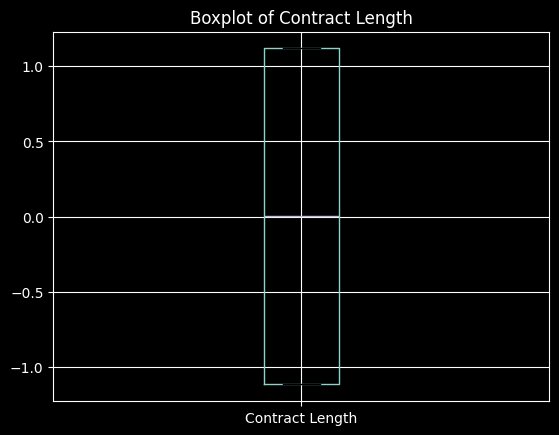

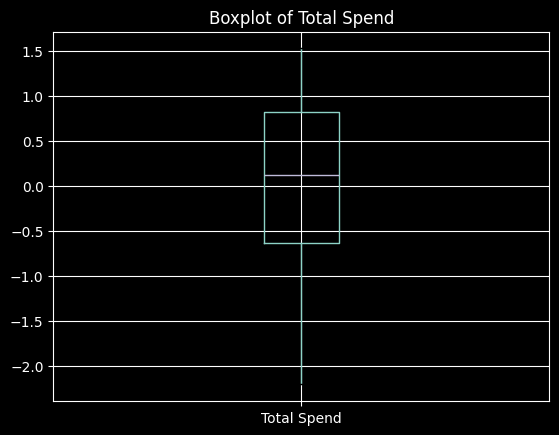

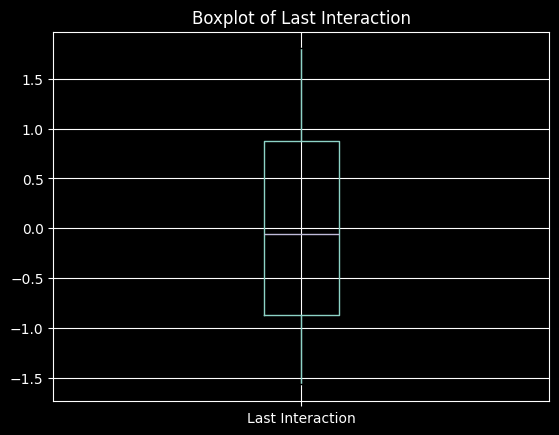

Shape after outlier removal: (440833, 12)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Boxplots for all numerical features
num_cols = df.select_dtypes(include=np.number).columns.drop('Churn', errors='ignore')
for col in num_cols:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

# Remove outliers using Z-score (threshold=3)
z_scores = np.abs(zscore(df[num_cols]))
df_no_outliers = df[(z_scores < 3).all(axis=1)]
print("Shape after outlier removal:", df_no_outliers.shape)

2. Advanced Feature Engineering
a. Interaction Features

In [27]:
# Example: Interaction between 'MonthlyCharges' and 'tenure'
if 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
    df['MonthlyCharges_tenure'] = df['MonthlyCharges'] * df['tenure']

b. Binning Numerical Features

In [28]:
# Example: Binning 'MonthlyCharges'
if 'MonthlyCharges' in df.columns:
    df['MonthlyCharges_bin'] = pd.cut(df['MonthlyCharges'], bins=5, labels=False)

3. Different Encoding (One-Hot & Target Encoding)
a. One-Hot Encoding

In [30]:
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

b. Target Encoding (using category_encoders)

In [32]:
%pip install category_encoders
import category_encoders as ce

# Target encode all categorical columns in cat_cols
encoder = ce.TargetEncoder(cols=cat_cols)
df_target_encoded = df.copy()
df_target_encoded[cat_cols] = encoder.fit_transform(df[cat_cols], df['Churn'])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


4. Class Imbalance Handling (SMOTE Example)

In [37]:
%pip install --upgrade scikit-learn imbalanced-learn

from imblearn.over_sampling import SMOTE

X = df.drop('Churn', axis=1)
y = df['Churn']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("After SMOTE:", X_res.shape, y_res.value_counts())

  Using cached scikit_learn-1.7.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation' (/Users/manojrammopati/Projects/ds_template/CustomerChurn_Prediction/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py)

In [39]:
%pip install --upgrade scikit-learn imbalanced-learn category_encoders

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Use the already defined num_cols and cat_cols if available
# Otherwise, infer from X
try:
    num_cols
except NameError:
    num_cols = X.select_dtypes(include=np.number).columns
try:
    cat_cols
except NameError:
    cat_cols = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier())
])

pipeline.fit(X, y)

  Using cached scikit_learn-1.7.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation' (/Users/manojrammopati/Projects/ds_template/CustomerChurn_Prediction/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier()
rf.fit(X, y)
selector = SelectFromModel(rf, prefit=True, threshold='median')
X_selected = selector.transform(X)
print("Selected features shape:", X_selected.shape)

ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation' (/Users/manojrammopati/Projects/ds_template/CustomerChurn_Prediction/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py)

In [41]:
# 5. Save the preprocessed data
df.to_csv('data/processed/preprocessed.csv', index=False)
print("Preprocessing complete. Data saved to data/processed/preprocessed.csv")

Preprocessing complete. Data saved to data/processed/preprocessed.csv


### Remove columns with too many missing values or low variance
### Remove highly correlated features
### Scale numerical features for better model performance
### Save the final preprocessed dataset

# Loading and comparing visually Both EDA AND PRE-PROCESSED Datasets 

In [42]:
import pandas as pd

eda_df = pd.read_csv('data/processed/eda_cleaned.csv')
pre_df = pd.read_csv('data/processed/preprocessed.csv')

2. Compare Shapes and Columns

In [43]:
print("EDA data shape:", eda_df.shape)
print("Preprocessed data shape:", pre_df.shape)

print("\nEDA columns:", eda_df.columns.tolist())
print("\nPreprocessed columns:", pre_df.columns.tolist())

EDA data shape: (440833, 12)
Preprocessed data shape: (440833, 12)

EDA columns: ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']

Preprocessed columns: ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']


3. Compare Summary Statistics

In [44]:
print("EDA Data Description:\n", eda_df.describe())
print("\nPreprocessed Data Description:\n", pre_df.describe())

EDA Data Description:
           CustomerID            Age         Tenure  Usage Frequency  \
count  440833.000000  440833.000000  440833.000000    440833.000000   
mean   225398.669604      39.373153      31.256337        15.807494   
std    129531.771637      12.442355      17.255708         8.586232   
min         2.000000      18.000000       1.000000         1.000000   
25%    113622.000000      29.000000      16.000000         9.000000   
50%    226125.500000      39.000000      32.000000        16.000000   
75%    337739.000000      48.000000      46.000000        23.000000   
max    449999.000000      65.000000      60.000000        30.000000   

       Support Calls  Payment Delay    Total Spend  Last Interaction  \
count  440833.000000  440833.000000  440833.000000     440833.000000   
mean        3.604435      12.965719     631.616289         14.480867   
std         3.070215       8.258053     240.802732          8.596198   
min         0.000000       0.000000     100.00000

4. Visualize Distributions (Numerical Columns)

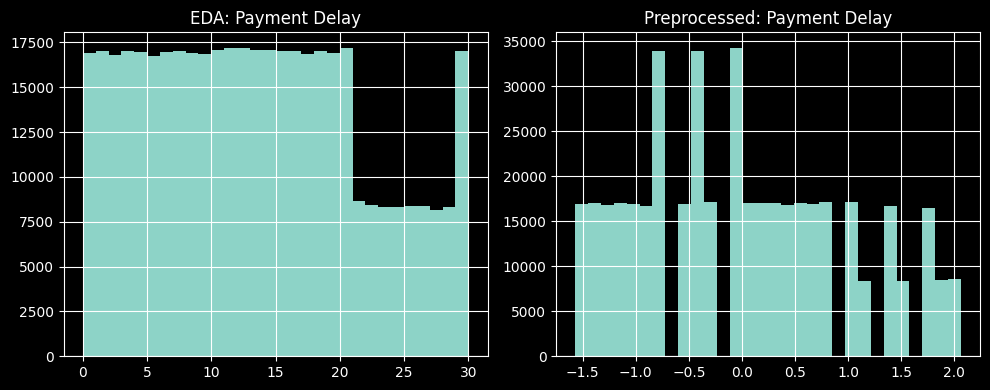

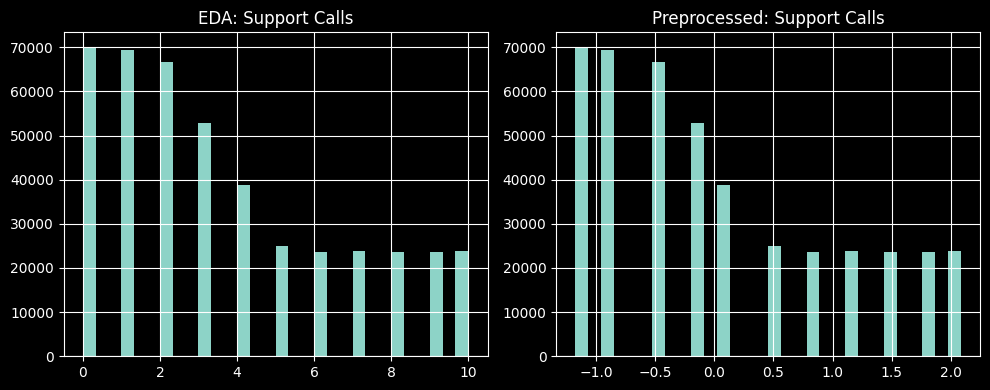

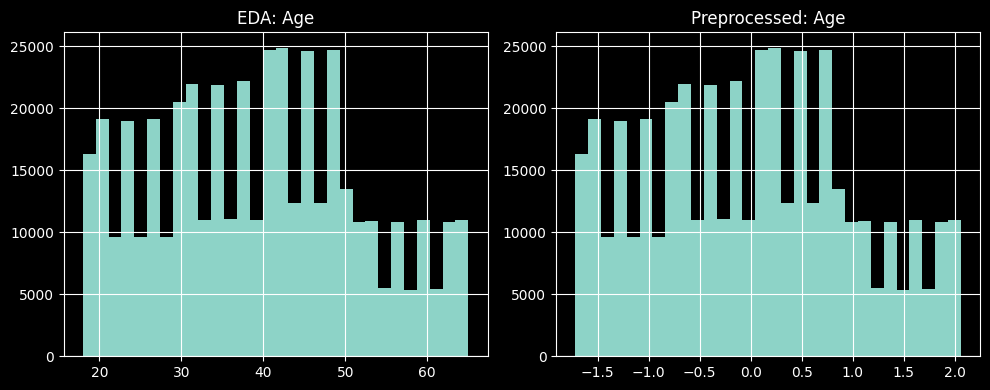

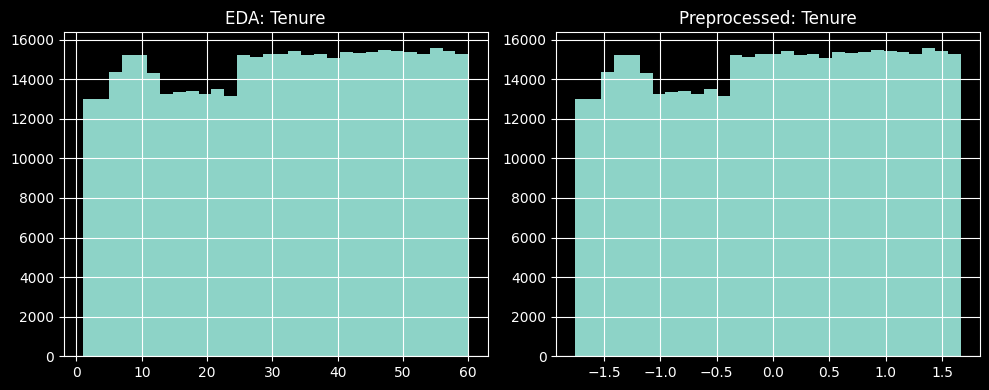

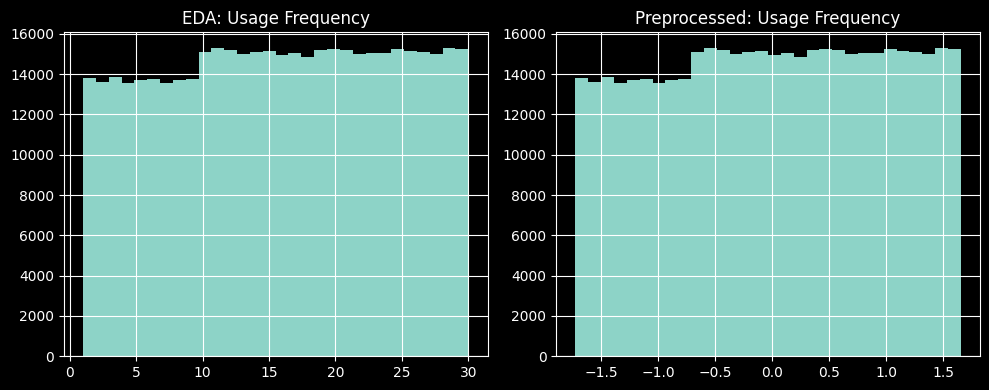

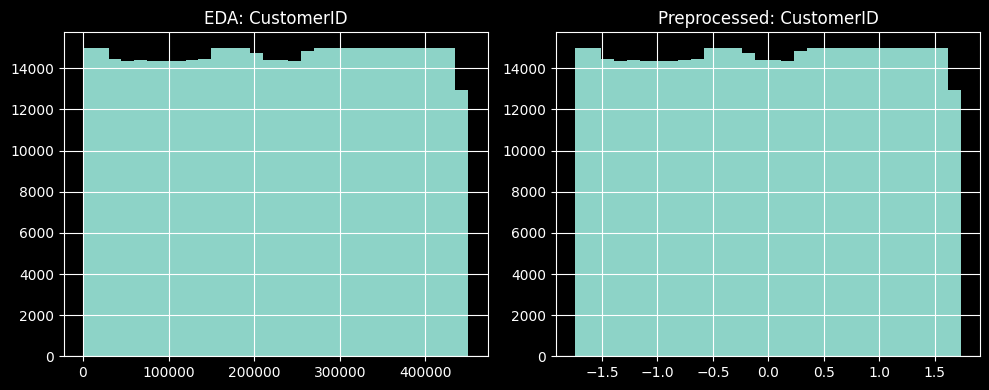

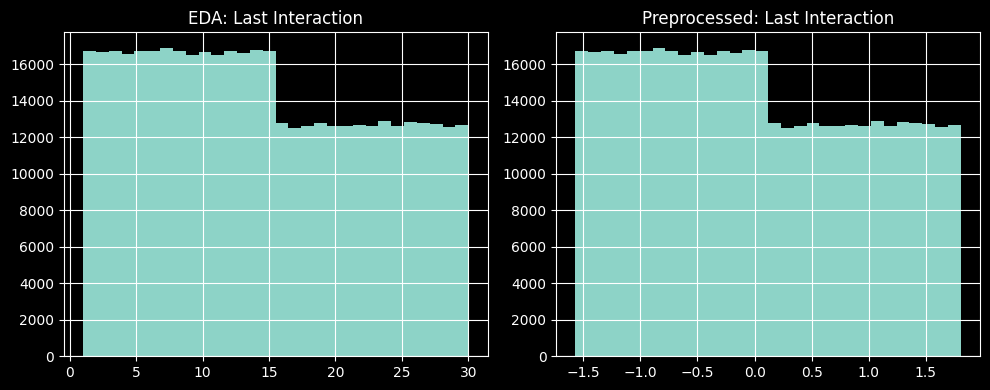

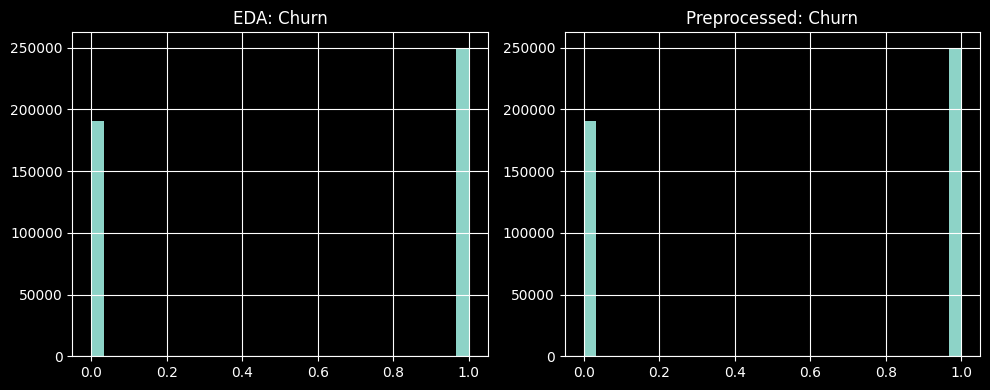

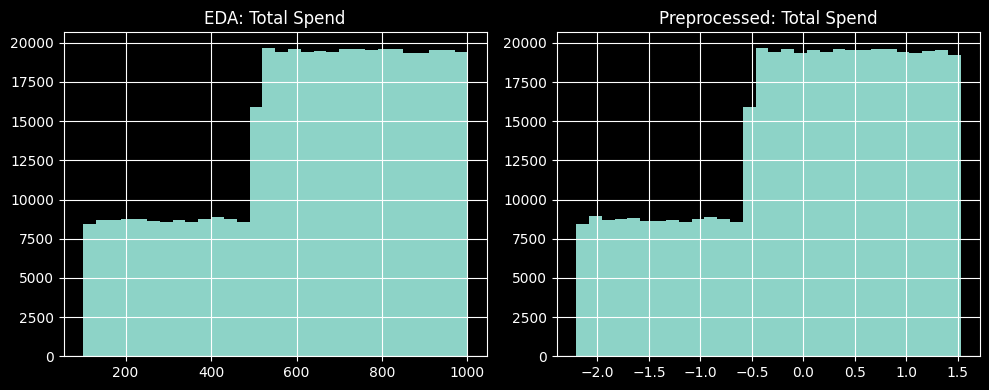

In [45]:
import matplotlib.pyplot as plt

num_cols_eda = eda_df.select_dtypes(include='number').columns
num_cols_pre = pre_df.select_dtypes(include='number').columns

for col in set(num_cols_eda).intersection(num_cols_pre):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    eda_df[col].hist(bins=30)
    plt.title(f'EDA: {col}')
    plt.subplot(1,2,2)
    pre_df[col].hist(bins=30)
    plt.title(f'Preprocessed: {col}')
    plt.tight_layout()
    plt.show()

5. Visualize Target Distribution

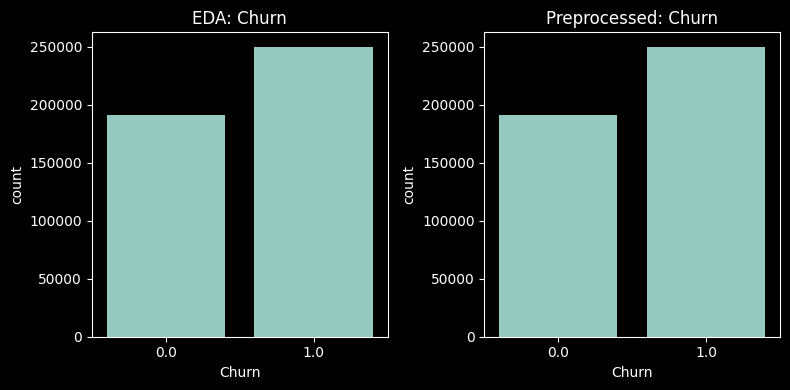

In [46]:
import seaborn as sns

if 'Churn' in eda_df.columns and 'Churn' in pre_df.columns:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.countplot(x='Churn', data=eda_df)
    plt.title('EDA: Churn')
    plt.subplot(1,2,2)
    sns.countplot(x='Churn', data=pre_df)
    plt.title('Preprocessed: Churn')
    plt.tight_layout()
    plt.show()

6. Compare Correlation Matrices

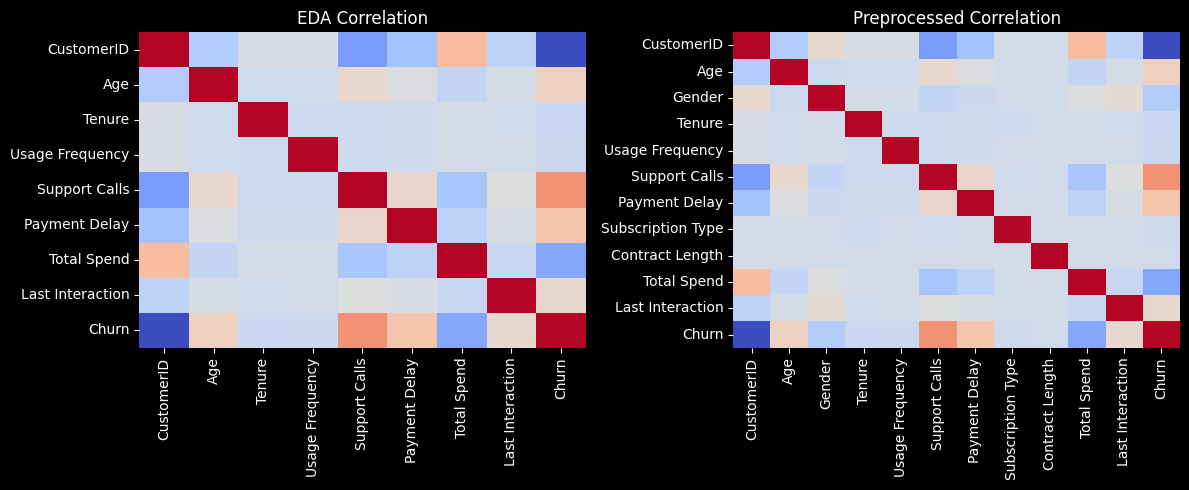

In [47]:
import seaborn as sns

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(eda_df.select_dtypes(include='number').corr(), cmap='coolwarm', cbar=False)
plt.title('EDA Correlation')
plt.subplot(1,2,2)
sns.heatmap(pre_df.corr(), cmap='coolwarm', cbar=False)
plt.title('Preprocessed Correlation')
plt.tight_layout()
plt.show()